In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from random import sample, seed

In [2]:
# six interactome datasets
interactome = pd.read_pickle('./data/Interactome.Datasets.merge-v2.pkl')
interactome_List = interactome['dataset'].unique().tolist()
# condensate-forming proteins
condFormProt_df = pd.read_pickle('./reults_data/human.condensate-formation.proteins-v1.pkl')
condFormProt_List = list(set(condFormProt_df['uniprot_entry']))

In [3]:
ltp = condFormProt_df[condFormProt_df['source']=='literature']['uniprot_entry'].tolist()

In [4]:
print(len(condFormProt_List), len(ltp))

3690 725


In [ ]:
cophase_raw = pd.read_excel('/home/lyz/PhaSepGAT/OtherVisualization/data/file-2_Co-Phase Separation Lists - 0326.xlsx', sheet_name=4)
cophase_df = cophase_raw[cophase_raw['Database'].str.contains('PhaSepDB2.0')][['UniProt Entry 1', 'UniProt Entry 2']].reset_index(drop=True)
cophase_df.columns = [0, 1]
cophase_df[0] = cophase_df[0].apply(lambda x: x.split('-')[0])
cophase_df[1] = cophase_df[1].apply(lambda x: x.split('-')[0])
cophase_df[2] = np.sort(cophase_df[[0, 1]].values).sum(axis=1)

In [6]:
cophase_ppi = cophase_df.drop_duplicates([2]).reset_index(drop=True)

In [7]:
x = 'HuRI'
# ppis from dataset
set1 = set(interactome[interactome['dataset']==x][0])
# co-phase interactions
set2 = set(cophase_ppi[2])
# coverage
len(set1 & set2) / len(set1)

0.00031594952706305167

In [9]:
# 各个数据集对于CoPhase的覆盖程度
for x in interactome_List:
    # ppis from dataset
    set1 = set(interactome[interactome['dataset']==x][0])
    # co-phase interactions
    set2 = set(cophase_ppi[2])
    # coverage
    coverage = len(set1 & set2) / len(set2)
    print(x, coverage)

HuRI 0.11347517730496454
BioPlex3.0 0.18439716312056736
Human Cell Map 0.04964539007092199
QUBIC 0.10638297872340426
CoFrac 0.0425531914893617


In [10]:
# 各个数据集对PS蛋白的覆盖程度
for x in interactome_List:
    tmp = interactome[interactome['dataset']==x].copy()
    # proteomes from dataset
    set1 = set(pd.concat([tmp['uniprot_id_0'], tmp['uniprot_id_1']]))
    # phase separated proteins with ltp evidences
    set2 = set(ltp)
    # coverage
    coverage = len(set1 & set2) / len(set2)
    print(x, coverage)

HuRI 0.5117241379310344
BioPlex3.0 0.886896551724138
Human Cell Map 0.5531034482758621
QUBIC 0.6910344827586207
CoFrac 0.45517241379310347


In [27]:
def f1(x):
    tmp = interactome[interactome['dataset']==x].copy()
    # proteomes from dataset
    set1 = set(pd.concat([tmp['uniprot_id_0'], tmp['uniprot_id_1']]))
    # phase separated proteins with ltp evidences
    set2 = set(ltp)
    # coverage
    return len(set1 & set2) / len(set2)

def f2(x):
    # ppis from dataset
    set1 = set(interactome[interactome['dataset']==x][0])
    # co-phase interactions
    set2 = set(cophase_ppi[2])
    # coverage
    return len(set1 & set2) / len(set2)

In [35]:
datCov = pd.DataFrame({
    x: [f1(x)] for x in interactome_List
}).T.reset_index()
datCov.columns = ['dataset', 'cov.psp']

datCov2CoPha_dict = {
    x: f2(x) for x in interactome_List
}
datCov['cov.copha'] = datCov['dataset'].map(datCov2CoPha_dict)

# datCov

In [36]:
datCov

,dataset,cov.psp,cov.copha
0,HuRI,0.511724,0.113475
1,BioPlex3.0,0.886897,0.184397
2,Human Cell Map,0.553103,0.049645
3,QUBIC,0.691034,0.106383
4,CoFrac,0.455172,0.042553


In [11]:
import matplotlib.pyplot as plt  
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [12]:
# color legend
interactome2color_dict = {
    'HuRI': '#E377C1',
    'BioPlex3.0': '#006699',
    'Human Cell Map': '#FF7F0E',
    'QUBIC': '#166433',
    'CoFrac': '#9366BD'
}

In [67]:
# FONTSIZE
YTICKLABELS = 12
XTICKLABELS = 10
LABEL = 15
TITLE = 25

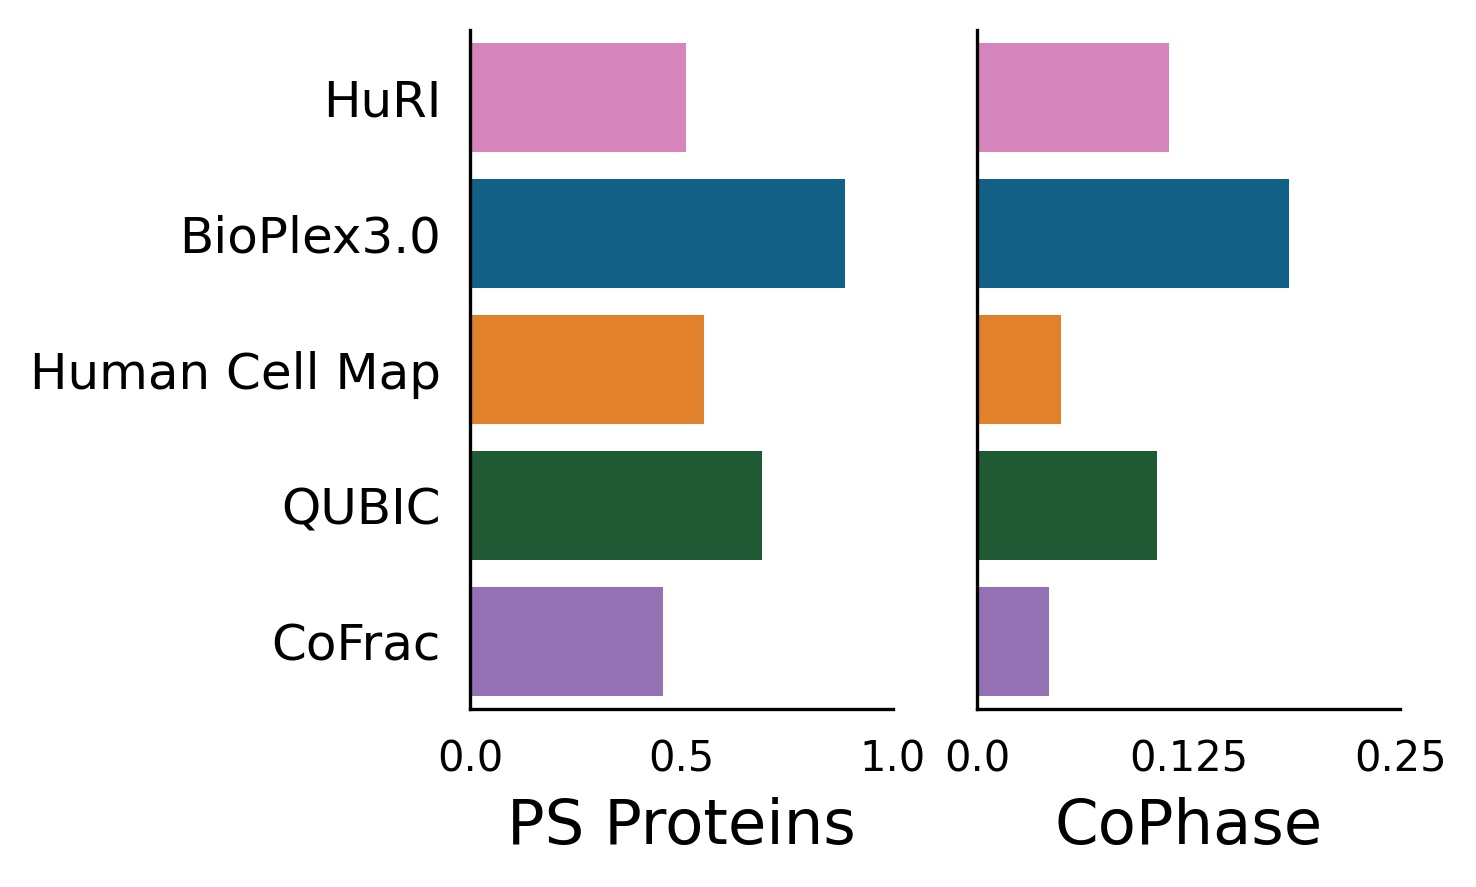

In [74]:
fig, axs = plt.subplots(
    figsize = [4, 3],
    ncols = 2, nrows = 1,
    sharey = True
)
plt.subplots_adjust(wspace = .2)
ax1, ax2 = axs

# plot-1
sns.barplot(
    y = 'dataset',
    x = 'cov.psp',
    data = datCov,
    palette = interactome2color_dict.values(),
    ax = ax1
)

ax1.set_ylabel(None)
ax1.set_xlabel('PS Proteins', size=LABEL)
ax1.set_yticklabels(interactome2color_dict.keys(), size=YTICKLABELS)
ax1.set_xlim([0, 1])
ax1.set_xticks(np.arange(0, 1.5, .5))
ax1.set_xticklabels([str(s) for s in np.arange(0, 1.5, .5)], size=XTICKLABELS)
for i in ['top', 'right']: ax1.spines[i].set_visible(False)
ax1.tick_params(axis='both', bottom = False, left=False)
    
# plot-2
sns.barplot(
    y = 'dataset',
    x = 'cov.copha',
    data = datCov,
    palette = interactome2color_dict.values(),
    ax = ax2
)

ax2.set_ylabel(None)
ax2.set_xlabel('CoPhase', size=LABEL)
ax2.set_yticklabels(interactome2color_dict.keys(), size=YTICKLABELS)
ax2.set_xlim([0, .25])
ax2.set_xticks(np.arange(0, .255, .125))
ax2.set_xticklabels([str(s) for s in np.arange(0, .255, .125)], size=XTICKLABELS)
for i in ['top', 'right']: ax2.spines[i].set_visible(False)
ax2.tick_params(axis='both', bottom = False, left=False)